# Model training


In [1]:

import matplotlib.pyplot as plt
import torch
import glob
from natsort import natsorted
from swincell.utils.utils import load_default_config
from swincell.utils.data_utils import flow_reshaped, split_dataset_folder, flow_generationd
# import warnings
# warnings.filterwarnings('ignore')


/home/xzhang/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configure training parameters

For this demo, the input image is downsampled by 2 along each dimension. (args.downsample_factor = 2)

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = '../../colon_dataset/colon_demo/'
args =load_default_config()
args.data_dir=data_dir
args.dataset = 'colon'
args.roi_x = 128
args.roi_y = 128
args.roi_z = 32
args.max_epochs = 200
args.a_min = 0
args.a_max = 255
args.save_logits = False

args.downsample_factor = 2 # downsample the input image if resolution is too high





In [3]:
image_files = natsorted(glob.glob(data_dir +'images/*tif*'))
mask_files = natsorted(glob.glob(data_dir +'labels/*tif*'))#

train_datalist, test_datalist = split_dataset_folder(image_files,mask_files, split_ratios=[0.8,0.2])
# train_datalist, val_datalist, test_datalist = split_dataset(data_dir, split_ratios=[0.6,0.2,0.2])
print(len(train_datalist),len(test_datalist))




4 1


In [4]:
if args.dataset =='colon':
    
    img_shape= (1300,1030,129) #original shape
    img_reshape = (img_shape[0]//args.downsample_factor,img_shape[1]//args.downsample_factor,img_shape[2]//args.downsample_factor)
    img_reshape = tuple(int(e) for e in img_reshape)

elif args.dataset =='allen':

    img_shape=(900,600,64)
    img_reshape = (img_shape[0]//args.downsample_factor,img_shape[1]//args.downsample_factor,img_shape[2]//args.downsample_factor)
    img_reshape = tuple(int(e) for e in img_reshape)

elif args.dataset =='nanolive':

    img_shape=(512,512,96)
    img_reshape = (img_shape[0]//args.downsample_factor,img_shape[1]//args.downsample_factor,img_shape[2]//args.downsample_factor)
    img_reshape = tuple(int(e) for e in img_reshape)

else:
    raise Warning("dataset not defined")
    img_reshape = None


In [5]:
from monai import data, transforms
train_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.EnsureChannelFirstd(keys=["image", "label"]),
        transforms.Resized(keys=["image", "label"],spatial_size=img_reshape),
        # transforms.RandZoomd(keys=["image", "label"],prob=1,min_zoom=0.2,max_zoom=5),
        # transforms.Spacingd(
        #     keys=["image", "label"], pixdim=(args.space_x, args.space_y, args.space_z), mode=("bilinear", "nearest")
        # ),
        transforms.ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=255, b_min=0, b_max=1, clip=True
        ),
        transforms.RandSpatialCropSamplesd(
            keys=["image","label"],
            # roi_size=[64,64,32],
            roi_size=[args.roi_x,args.roi_y,args.roi_z],
            num_samples=2,
            random_center=True,
            random_size=False,
        ),
        flow_generationd(keys=["label"]),

        # transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=0.1),
        # transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=0.1),
        transforms.ToTensord(keys=["image", "label"]),
    ]
)
test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.Resized(keys=["image", "label"],spatial_size=img_reshape),
        # transforms.AsDiscreted(keys=["label"],threshold=1),
        # transforms.AddChanneld(keys=["image", "label"]),
        # transforms.Resized(keys=["image", "label"],spatial_size=(512,512,96)),
        transforms.ScaleIntensityRanged(
            # keys=["image"], a_min=21000, a_max=31000, b_min=0, b_max=1, clip=True
            keys=["image"], a_min=0, a_max=255, b_min=0, b_max=1, clip=True
        ),
        transforms.ToTensord(keys=["image"]),
    ]
)

train_ds = data.Dataset(data=train_datalist, transform=train_transform)
train_loader = data.DataLoader(
        train_ds, batch_size=1, num_workers=2, sampler=None, drop_last=True
    )
test_ds = data.Dataset(data=test_datalist, transform=test_transform)
test_loader = data.DataLoader(
        test_ds, batch_size=1, num_workers=2, sampler=None, drop_last=True
)

## visualize training data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img/label/2plot shape torch.Size([2, 1, 128, 128, 32]) torch.Size([2, 4, 128, 128, 32])
torch.Size([128, 128]) (128, 128, 3)
2.0 -2.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img/label/2plot shape torch.Size([2, 1, 128, 128, 32]) torch.Size([2, 4, 128, 128, 32])
torch.Size([128, 128]) (128, 128, 3)
2.0 -2.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img/label/2plot shape torch.Size([2, 1, 128, 128, 32]) torch.Size([2, 4, 128, 128, 32])
torch.Size([128, 128]) (128, 128, 3)
2.0 -2.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img/label/2plot shape torch.Size([2, 1, 128, 128, 32]) torch.Size([2, 4, 128, 128, 32])
torch.Size([128, 128]) (128, 128, 3)
2.0 -2.0


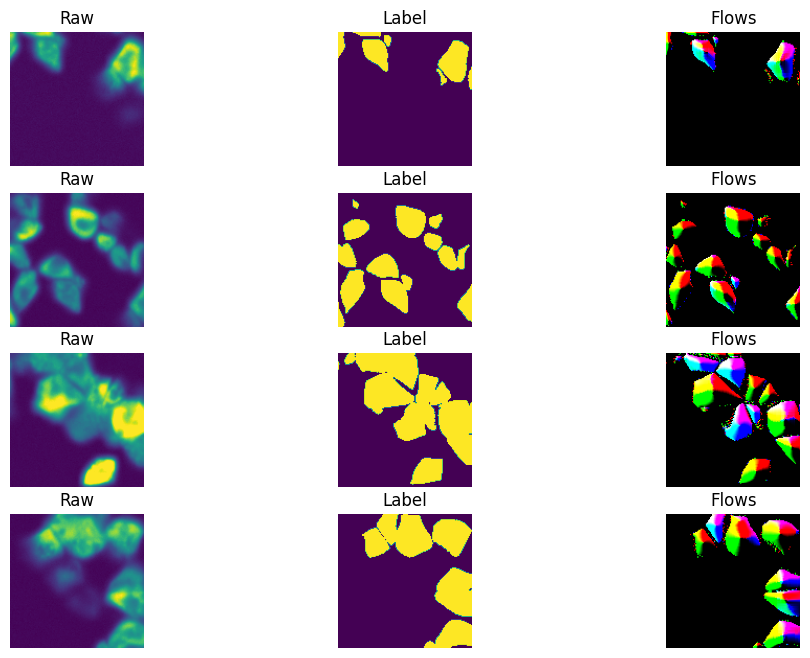

In [6]:
N_samples = 4
fig, axes = plt.subplots(N_samples, 3,sharex=False, sharey=False, figsize=(12,8))
n=0

slice2view = int(args.roi_z//2)
for i in range(N_samples):
    datai = next(iter(train_loader))
    img2plot=datai['image']
    label2plot=datai['label']
    # print('img/label/2plot shape',img2plot.shape, label2plot.shape)

    top= torch.max(img2plot[0,0,:,:,:],dim=-1)[0].detach().cpu()

    mask0= label2plot[0,0,:,:,slice2view].detach().cpu()
    flow= label2plot[0,1:4,:,:,slice2view].detach().cpu().numpy().transpose(1, 2, 0)
    # print(mask0.shape,flow.shape)
    # print(flow.max(),flow.min())
    axes[i,0].imshow(img2plot[0,0,:,:,slice2view])
    axes[i,0].set_title('Raw')
    
    axes[i,1].imshow(mask0)
    axes[i,1].set_title('Label')

    axes[i,2].imshow(flow)
    axes[i,2].set_title('Flows')

    # axes[i,3].imshow(label2plot[0,1,:,:,slice2view].detach().cpu().numpy())
    # axes[i,3].set_title('Flows')
    # axes[i,4].imshow(label2plot[0,2,:,:,slice2view].detach().cpu().numpy())
    # axes[i,4].set_title('Flows')
    # axes[i,5].imshow(label2plot[0,3,:,:,slice2view].detach().cpu().numpy())
    # axes[i,5].set_title('Flows')
    for col in range(3):
      axes[i,col].axis('off')



In [8]:

from swincell.utils.utils import AverageMeter, load_model

from torch.nn import MSELoss,BCEWithLogitsLoss
from monai.losses import DiceLoss

model = load_model(args).to(device)

loss1 = MSELoss(reduction='mean')
loss2 = DiceLoss(to_onehot_y=False, sigmoid=True)
losses = [loss1,loss2]

optimizer = torch.optim.Adam(model.parameters(), lr=args.optim_lr, weight_decay=1e-5)

# Model training

In [9]:
from swincell.trainer import train_epoch, save_checkpoint
import time

train_losses = []
for epoch in range(args.max_epochs):
    epoch_time = time.time()
    train_loss, train_img_list = train_epoch(
            model, train_loader, optimizer, epoch=epoch, loss_func=losses, args=args
        )
    print(
                "Training  {}/{}".format(epoch, args.max_epochs - 1),
                "loss: {:.4f}".format(train_loss),
                "time {:.2f}s".format(time.time() - epoch_time),
            )
    train_losses.append(train_loss)






Epoch 0/1000 0/4 loss: 4.0810 time 22.93s
Epoch 0/1000 1/4 loss: 4.5442 time 6.48s
Epoch 0/1000 2/4 loss: 4.4793 time 14.86s
Epoch 0/1000 3/4 loss: 4.2664 time 2.84s
Training  0/999 loss: 4.2664 time 47.15s
Epoch 1/1000 0/4 loss: 3.8871 time 20.61s
Epoch 1/1000 1/4 loss: 3.8836 time 2.63s
Epoch 1/1000 2/4 loss: 3.6368 time 9.50s
Epoch 1/1000 3/4 loss: 3.3542 time 0.37s
Training  1/999 loss: 3.3542 time 33.16s
Epoch 2/1000 0/4 loss: 4.0123 time 32.03s
Epoch 2/1000 1/4 loss: 4.0206 time 1.33s
Epoch 2/1000 2/4 loss: 4.5083 time 39.63s
Epoch 2/1000 3/4 loss: 4.0086 time 0.37s
Training  2/999 loss: 4.0086 time 73.40s
Epoch 3/1000 0/4 loss: 3.8250 time 29.79s
Epoch 3/1000 1/4 loss: 4.0583 time 5.98s
Epoch 3/1000 2/4 loss: 3.9270 time 17.66s
Epoch 3/1000 3/4 loss: 3.8986 time 9.65s
Training  3/999 loss: 3.8986 time 63.14s
Epoch 4/1000 0/4 loss: 3.2406 time 27.91s
Epoch 4/1000 1/4 loss: 2.6724 time 0.37s
Epoch 4/1000 2/4 loss: 3.1488 time 30.60s
Epoch 4/1000 3/4 loss: 3.2577 time 0.37s
Trainin

KeyboardInterrupt: 

In [10]:
# uncomment to save final model locally
# save_model_name = 'demo_model_12812832_otf_1000epoch_dsp2.pt'
# save_checkpoint(model, epoch, args,save_model_name, best_acc=0, optimizer=optimizer)


Saving checkpoint demo_model_12812832_otf_1000epoch_dsp2.pt


Text(0.5, 1.0, 'Training loss')

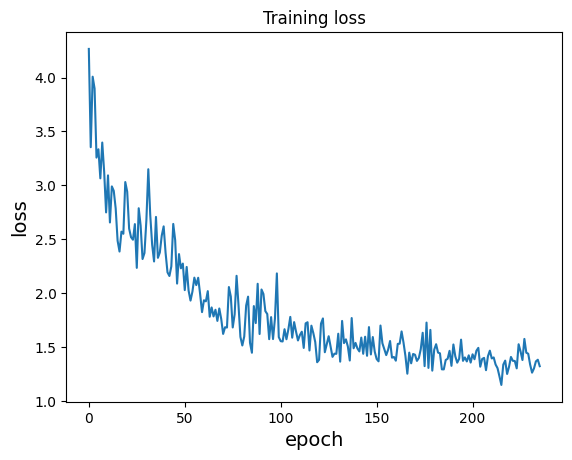

In [11]:
#plot loss
plt.plot(train_losses)
plt.xlabel('epoch', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.title('Training loss')


# For inference with pretrained models:
uncomment to load pretrained and presaved models

In [9]:
# load pretrained model
# save_model_name = 'demo_model_12812832_otf.pt'
# model_dict = torch.load(save_model_name)["state_dict"]
# model.load_state_dict(model_dict)

# predefined_model_path = '/home/xzhang/Projects/swincell_backup/runs/colon_cellpose_swinunetr_128_128_32_v2_1_255_colon_30/foldNone/model_final.pt'
# model_dict = torch.load(predefined_model_path)["state_dict"]
# model.load_state_dict(model_dict)

<All keys matched successfully>

# Data inference with the trained model

In [12]:
import numpy as np
import os
infer_ROI = (256,256,32)
output_folder = data_dir + 'output/'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)


In [13]:

test_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.EnsureChannelFirstd(keys=["image", "label"]),
            # flow_reshaped(keys=["label"]),
            transforms.Resized(keys=["image", "label"],spatial_size=img_reshape),
            transforms.ScaleIntensityRanged(
                keys=["image"], a_min=args.a_min, a_max=args.a_max, b_min=args.b_min, b_max=args.b_max, clip=True
            ),

            transforms.ToTensord(keys=["image", "label"]),
        ]
    )


test_ds = data.Dataset(data=test_datalist, transform=test_transform)
test_loader = data.DataLoader(
        test_ds, batch_size=1, sampler=None, drop_last=False
    )

In [14]:
from monai.transforms import (
    AsDiscrete,
    Activations,
)
from functools import partial
from monai.inferers import sliding_window_inference
import tifffile
from swincell.cellpose_dynamics import compute_masks

model_inferer = partial(
    sliding_window_inference,
    roi_size=infer_ROI,
    sw_batch_size=2,
    predictor=model,
    overlap=0.5,
    mode='gaussian'
)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)
with torch.no_grad():
        for idx, batch_data in enumerate(test_loader):
            out_filename = test_datalist[idx]['image'].split('.')[0].split('/')[-1] +'_pred.tiff' 
            data_test = batch_data["image"]
            data_test = data_test.cuda(device)
    
            logits = model_inferer(data_test)         

            logits_out =  np.squeeze(logits.detach().cpu().numpy())
            

            logits_out[0] = post_pred(post_sigmoid(logits_out[0]))

            logits_out_transposed = np.transpose(logits_out,(0,3,2,1))
            flows = logits_out[1:4,:,:,:]
            if args.save_logits:
                tifffile.imwrite(output_folder +'/pred_logits_transposed,'+out_filename ,logits_out_transposed)
            
            # print(logits.shape, logits.max(),logits.min())
            masks_recon,p = compute_masks(logits_out_transposed[[3,2,1],:,:,:],logits_out_transposed[0,:,:,:],cellprob_threshold=0.4,flow_threshold=0.4, do_3D=True,min_size=2500//args.downsample_factor//args.downsample_factor, use_gpu=True)
            
            print(masks_recon.shape)

torch.Size([1, 1, 650, 515, 64])
logits shape (4, 650, 515, 64)
logits shape (4, 650, 515, 64)
4.015282 -3.5039515
torch.Size([1, 4, 650, 515, 64]) metatensor(7.1327, device='cuda:0') metatensor(-3.5040, device='cuda:0')


# visualize prediction results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


slice to view 32
(650, 515, 64) (4, 650, 515, 64)
(3, 650, 515, 64)


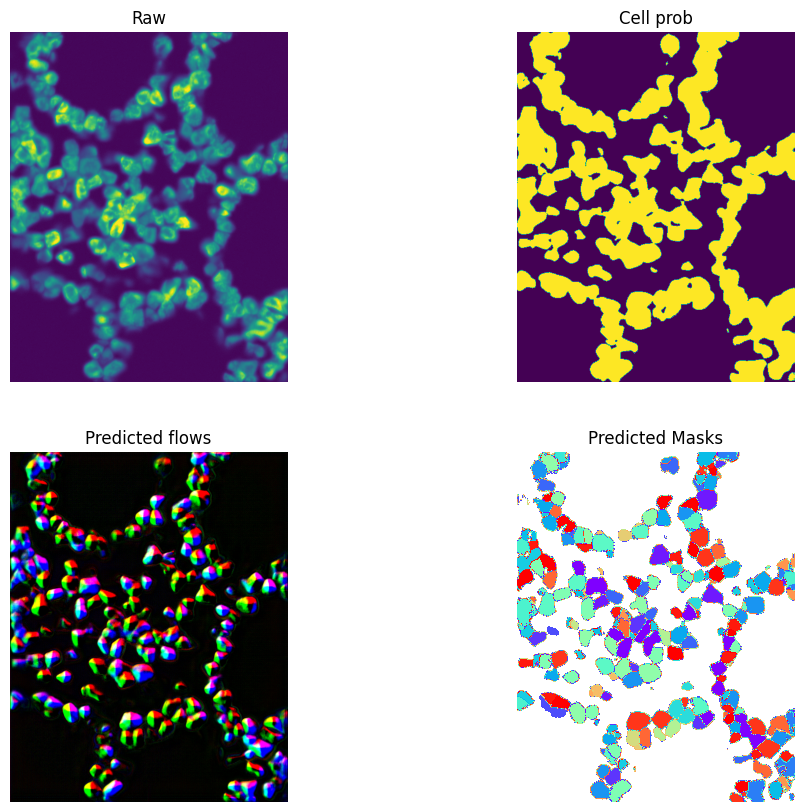

In [17]:
from swincell.utils.plot_utils import get_random_cmap
n_row = 2
fig, axes = plt.subplots(2, 2,sharex=False, sharey=False, figsize=(12,10))
img_shape = logits.shape
slice2view = int(img_shape[-1]//2)
print('slice to view',slice2view)
# datai = next(iter(test_loader))
img=np.squeeze(data_test.detach().cpu().numpy())
print(img.shape,logits_out.shape)
flow= logits_out[1:4]
flow_slice = flow[:,:,:,slice2view].transpose(1, 2, 0)
print(flow.shape)


axes[0,0].imshow(img[:,:,slice2view])
axes[0,0].set_title('Raw')

axes[0,1].imshow(logits_out[0,:,:,slice2view])
axes[0,1].set_title('Cell prob')

axes[1,0].imshow(flow_slice)
axes[1,0].set_title('Predicted flows')                                                                                       


axes[1,1].imshow(masks_recon[slice2view].T,cmap=get_random_cmap(30))
axes[1,1].set_title('Predicted Masks')

for i in range(2):
    for j in range(2):
        axes[i,j].axis('off')

# empty cache

In [23]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()